In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
import itertools
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

from datetime import datetime, timedelta, timezone



In [5]:

def get_BJ_time():
    # 拿到UTC时间，并强制设置时区为UTC+0:00
    utc_dt = datetime.utcnow().replace(tzinfo=timezone.utc)
    # astimezone()将转换时区为北京时间
    bj_dt = utc_dt.astimezone(timezone(timedelta(hours=8)))
    current_time = bj_dt.strftime('%m%d_%H-%M-%S')

    return current_time


# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("ResampledefficientB4.pdf")
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
from torch.utils.data.sampler import WeightedRandomSampler
 
__all__ = ['OverSamplingCallback']
 
class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner,weights:torch.Tensor=None):
        super().__init__(learn)
        self.weights = weights
 
    def on_train_begin(self, **kwargs):
        ds,dl = self.data.train_ds,self.data.train_dl
        self.labels = ds.y.items.astype(np.integer)
        assert np.issubdtype(self.labels.dtype, np.integer), "Can only oversample integer values"
        _,self.label_counts = np.unique(self.labels,return_counts=True)
        if self.weights is None: self.weights = torch.DoubleTensor((1/self.label_counts)[self.labels])
        self.total_len_oversample = int(self.data.c*np.max(self.label_counts))
        sampler = WeightedRandomSampler(self.weights, self.total_len_oversample)
        self.data.train_dl = dl.new(shuffle=False, sampler=sampler)

In [6]:
SEED = 2019
seed_everything(SEED)

current_time = get_BJ_time()
print(current_time)

df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

test_df = pd.read_csv('2019data/sample_submission.csv')

bs = 32 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# df_2015 = pd.read_csv('aptos-data-split/df_2015_cv.csv')
# df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')

# df = pd.concat([df_2015, df_2019]).reset_index(drop=True) # merge train val together
# df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

# test_df = pd.read_csv('2019data/sample_submission.csv')

data = (ImageList.from_df(df=df,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(y_pred.cpu().numpy().round(), y.cpu().numpy(), weights='quadratic'))

model_name = 'efficientnet-b4'
model = EfficientNet.from_pretrained(model_name, num_classes=1)
df_2019 = pd.read_csv('aptos-data-split/df_2019_cv.csv')
df_2019['is_valid'] = [False]*2929 + [True]*733
data_2019 = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
learn = Learner(data_2019, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = 'output/models/')
learn.data.add_test(ImageList.from_df(test_df,
                                      '2019data',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

print(fastai.__version__)
print(torch.__version__)

0401_03-10-07
Loaded pretrained weights for efficientnet-b4
1.0.61
1.4.0


In [4]:
# from torch.utils.data.sampler import WeightedRandomSampler

# class OverSamplingCallback(LearnerCallback):
#     def __init__(self,learn:Learner,weights:torch.Tensor=None):
#         super().__init__(learn)
#         self.labels = self.learn.data.train_dl.dataset.y.items
#         _, counts = np.unique(self.labels,return_counts=True)
#         self.weights = (weights if weights is not None else
#                         torch.DoubleTensor((1/counts)[self.labels.astype(int)]))
#         self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data for i in range(len(self.learn.data.train_dl.dataset))])
#         self.total_len_oversample = int(self.learn.data.c*np.max(self.label_counts))
        
#     def on_train_begin(self, **kwargs):
#         self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,self.total_len_oversample), self.learn.data.train_dl.batch_size,False)

In [7]:
df_2019test = pd.read_csv('2019data/train.csv')
train_2019="2019data/train_images_ben_preprocessing_sigmaX10/"
df_2019test['path'] = df_2019test['id_code'].map(lambda x: os.path.join(train_2019, '{}.png'.format(x)))

In [8]:

df_2019test['is_valid'] = [False]*2929 + [True]*733 

data_2020 = (ImageList.from_df(df=df_2019test,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )



learn = Learner(data_2020, 
                model, 
                metrics = [accuracy,qk],
                callback_fns=[OverSamplingCallback],
                model_dir = 'output/models/')
labels=learn.data.train_dl.dataset.y.items

# learn.callback_fns=[partial(OverSamplingCallback)]
# learn.data.train_dl.dataset.y.items=labels.astype(int)




In [9]:
learn.lr_find() 
# learn.recorder.plot(suggestion=True)


/environment/python/versions/miniconda3-4.7.12/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  if sys.path[0] == '':


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 6.92E-03


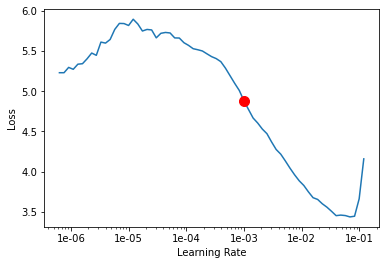

In [10]:
learn.recorder.plot(suggestion=True)

In [11]:
model_save_name = "ResampledEfficientNetWithPreprocessing"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20,   1.00E-03, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

/environment/python/versions/miniconda3-4.7.12/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  if sys.path[0] == '':


epoch,train_loss,valid_loss,accuracy,qk,time
0,4.255335,3.493962,0.527967,0.231410,00:18
1,2.009912,2.738477,0.527967,0.454369,00:18
2,1.163025,0.909634,0.527967,0.713707,00:18
3,0.837321,0.388544,0.527967,0.872066,00:18
4,0.657915,0.506919,0.527967,0.837137,00:18
5,0.613058,0.326165,0.527967,0.895516,00:18
6,0.552091,0.684871,0.527967,0.649070,00:18
7,0.530726,0.351824,0.527967,0.896533,00:18
8,0.453427,0.401809,0.527967,0.873955,00:18
9,0.431374,0.381969,0.527967,0.879715,00:18


Better model found at epoch 0 with valid_loss value: 3.493961811065674.
Better model found at epoch 1 with valid_loss value: 2.7384769916534424.
Better model found at epoch 2 with valid_loss value: 0.9096342325210571.
Better model found at epoch 3 with valid_loss value: 0.3885438144207001.
Better model found at epoch 5 with valid_loss value: 0.32616496086120605.
Better model found at epoch 14 with valid_loss value: 0.3143330216407776.
Better model found at epoch 15 with valid_loss value: 0.25957345962524414.
Model save as: ResampledEfficientNetWithPreprocessing


In [17]:

import scipy as sp
class OptimizedRounder(object):
    """
    Optimize threshold coefficients.
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [18]:
learn = Learner(data_2020, 
                model, 
                metrics = [qk],
                callback_fns=[OverSamplingCallback],
                model_dir = 'output/models/')
learn.load("transformed_testwithlr_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,1.0,0.0,4.0,2.0
Path: .;

Test: LabelList (1928 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: ., model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3)

/environment/python/versions/miniconda3-4.7.12/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  if sys.path[0] == '':


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 5.75E-03


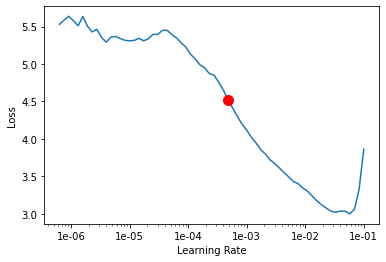

In [19]:
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [20]:
model_save_name = "ResampledEfficientNetB4WithPreprocessingOn2015"
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20, 4.79E-04, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

/environment/python/versions/miniconda3-4.7.12/envs/tf1.15/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  if sys.path[0] == '':


epoch,train_loss,valid_loss,qk,time
0,4.315294,1.351607,0.462234,00:18
1,2.212291,0.818106,0.686608,00:18
2,1.292153,0.551931,0.805951,00:18
3,0.865523,0.554059,0.774333,00:18
4,0.656696,0.373400,0.871864,00:18
5,0.566942,0.349859,0.886975,00:18
6,0.523167,0.335132,0.883090,00:18
7,0.463408,0.537522,0.831173,00:18
8,0.429052,0.376617,0.894384,00:18
9,0.406541,0.367005,0.874358,00:18


Better model found at epoch 0 with valid_loss value: 1.351606845855713.
Better model found at epoch 1 with valid_loss value: 0.8181063532829285.
Better model found at epoch 2 with valid_loss value: 0.5519314408302307.
Better model found at epoch 4 with valid_loss value: 0.37339967489242554.
Better model found at epoch 5 with valid_loss value: 0.34985899925231934.
Better model found at epoch 6 with valid_loss value: 0.33513176441192627.
Better model found at epoch 11 with valid_loss value: 0.30750778317451477.
Better model found at epoch 13 with valid_loss value: 0.26755234599113464.
Better model found at epoch 14 with valid_loss value: 0.2596217393875122.
Better model found at epoch 15 with valid_loss value: 0.2507861852645874.
Better model found at epoch 17 with valid_loss value: 0.2456195056438446.
Model save as: ResampledEfficientNetB4WithPreprocessingOn2015


In [21]:
learn.data.add_test(ImageList.from_df(test_df,
                                      '2019data',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])
coefficients = optR.coefficients()
print(coefficients)

0.9254741677315508
[0.530074 1.495352 2.464067 3.267254]


In [22]:
valid_pred = optR.predict(valid_preds[0], [0.5, 1.5, 2.5, 3.5])
cm = confusion_matrix(valid_preds[1],valid_pred)

In [23]:
cm

array([[375,  11,   1,   0,   0],
       [  5,  36,  19,   1,   0],
       [  0,  23, 122,  38,   2],
       [  0,   1,   9,  22,   3],
       [  0,   0,  12,  25,  28]])

Confusion matrix, without normalization
[[375  11   1   0   0]
 [  5  36  19   1   0]
 [  0  23 122  38   2]
 [  0   1   9  22   3]
 [  0   0  12  25  28]]


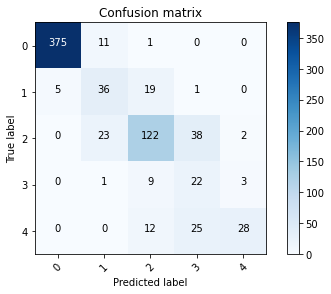

In [24]:
plot_confusion_matrix(cm, classes=range(5), normalize=False)

In [3]:
import numpy as np
cm= np.array([[375,5,0,0,0],
             [11,36,23,1,0],
             [1,19,122,9,12],
             [0,1,38,22,25],
             [0,0,2,3,28]])

Confusion matrix, without normalization
[[375   5   0   0   0]
 [ 11  36  23   1   0]
 [  1  19 122   9  12]
 [  0   1  38  22  25]
 [  0   0   2   3  28]]


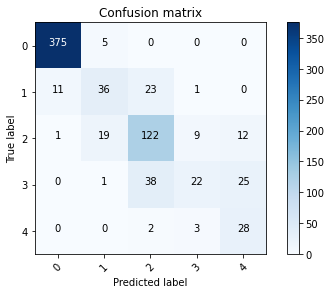

In [6]:
plot_confusion_matrix(cm, classes=range(5), normalize=False)